<h2 align='center'> Tugas Minggu 5 Deep Learning </h2>
<br>
<hr>
<br>
Nama: Muh. Yusuf Syam
<br>
NIM: H071191044
<br>
Soal: Pelajari Arsitektur CNN modern di <a href='https://d2l.ai/chapter_convolutional-modern/index.html'> D2L.AI Chapter 7: Modern Convolutional Neural Networks - Dive into Deep Learning<a/>

In [1]:
import tensorflow as tf
from tensorflow import keras

Data yang akan digunakan: mnist

In [2]:
(x_train, y_train), (x_test, y_test)= keras.datasets.mnist.load_data()
x_train, x_test= x_train/255, x_test/255

11501568/11490434 [==============================] - 0s 0us/step


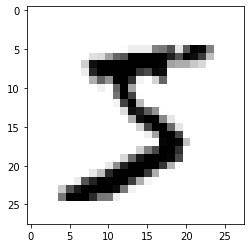

In [3]:
from matplotlib import pyplot as plt
plt.imshow(x_train[0], cmap='binary')

Karena arsitektur CNN modern membutuhkan input gambar dengan 3 dimensi, maka kita perlu mereshape data terlebih dahulu

In [4]:
new_x_train_shape= list(x_train.shape)
new_x_train_shape.append(1)
new_x_test_shape= list(x_test.shape)
new_x_test_shape.append(1)

x_train = x_train.reshape(new_x_train_shape)
x_test = x_test.reshape(new_x_test_shape)

x_train.shape

(60000, 28, 28, 1)

### Modern Convolutional Neural Networks

LeNet mempunyai performa yang baik untuk dataset yang relatif kecil, namun tidak untuk dataset yang lebih besar dan 'real' atau lebih general, untuk mengatasi masalah ini beberapa AI engineer menemukan arsitektur-arsitektur baru yang bukan hanya memiliki akurasi yang tinggi, tapi juga lebih mampu mengatasi dataset yang besar, dengan proses training yang cepat dengan penggunaan GPU. 
<br><br>
Arsitektur modern ini semuanya ditemukan setelah tahun 2012, ada 2 alasan utama dari hal tersebut:
* Kurangnya Data, dataset ImageNet berperan besar dalam mengatasi kekurangan data pada 2009
* Kurangnya kemampuan Hardware untuk pemrosesan (CPU), pada tahun 2012 Alex Krizhevsky dan Ilya Sutskever mengatasinya dengan membuat arsitektur yang bisa diproses dengan GPU (AlexNet)

Berikut beberapa arsitektur-arsitektur CNN modern:

### 1. AlexNet

AlexNet ditemukan oleh Alex Krizhevsky dan Ilya Sutskever pada tahun 2012, AlexNet merupakan pemenang dari kompetisi ImageNet Large Scale Visual Recognition Challenge 2012 dan merupakan arsitektur deep learning pertama yang berjalan pada GPU.
<br><br>
AlexNet cukup mirip dengan LeNet, bedanya AlexNet terdiri dari delapan layer: lima layer konvolusi, dua layer fcn, dan satu layer output, AlexNet juga menggunakan ReLU sebagai fungsi aktivasi. Berikut perbedaan LeNet(kiri) dengan AlexNet(kanan)

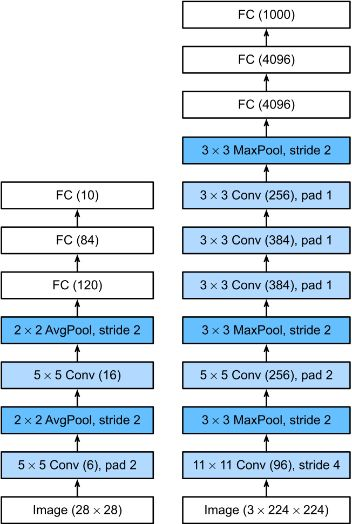

**Implementasi Kode**

In [5]:
alex_net= keras.models.Sequential([
        # Kita memodifikasi input_shape yang seharusnya (224,224,3) menjadi (224,224,1)
        keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu', input_shape=(224,224,1)),
        keras.layers.MaxPool2D(pool_size=3, strides=2),
        keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=3, strides=2),
        keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=3, strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(10)
    ])

Dataset mnist memiliki dimensi 28,28,1 , sementara AlexNet membutuhkan input berdimensi 224x224x3 , jadi kita perlu melakukan resize (upscale) pada gambar terlebih dahulu
<br><br>
Karena me-resize satu-satu gambar membutuhkan waktu yang lama, maka kita dapat menggunakan API ```tf.data.Dataset``` dari tensorflow untuk menulis input pipeline

In [6]:
# Mengcasting tipe dari numpy array menjadi tensor
x_train_224= tf.data.Dataset.from_tensor_slices(x_train)

# Melakukan resize 
x_train_224= x_train_224.map(lambda img: tf.image.resize(img, tf.constant([224, 224])), num_parallel_calls=tf.data.AUTOTUNE)
# x_train_224= x_train_224.cache('/')

Karena ```x_train_224``` merupakan generator dan ```model.fit()``` hanya mensupport generator jika generatornya merupakan pasangan x dan y, maka kita perlu memasangkan x dan y. Kita juga melakukan cache dan prefetch untuk mengefisienkan dan mempercepat proses training

In [7]:
# Menyatukan x dan y
train_data_224= tf.data.Dataset.zip((x_train_224, tf.data.Dataset.from_tensor_slices(y_train)))

train_data_224= train_data_224.shuffle(2)

# Caching
train_data_224= train_data_224.cache('/')

# Mendefinisikan batch
train_data_224= train_data_224.batch(128)

# Prefetch
train_data_224= train_data_224.prefetch(tf.data.experimental.AUTOTUNE)

Melakukan hal yang sama pada data tes

In [8]:
x_test_224= tf.data.Dataset.from_tensor_slices(x_test)
x_test_224= x_test_224.map(lambda img: tf.image.resize(img, tf.constant([224, 224])), num_parallel_calls=tf.data.AUTOTUNE)
test_data_224= tf.data.Dataset.zip((x_test_224, tf.data.Dataset.from_tensor_slices(y_test)))
test_data_224= test_data_224.batch(128)

Melakukan training, yang menjadi parameter training pengganti x dan y merupakan variabel ```train_data_224``` yang telah dibuat sebelumnya

In [9]:
loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer= keras.optimizers.Adam(learning_rate= 0.1)
# model_checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(filepath='weight_checkpoints/weight - epoch: {epoch:0.2f} - accuracy {accuracy:0.4f}.ckpt', monitor= 'accuracy', save_freq='epoch', save_weights_only=True)

Meng-compile dan train model, walaupun epochnya rendah namun mempunyai hasil yang cukup bagus

In [10]:
alex_net.compile(optimizer='adam', loss= loss, metrics=['accuracy'])
alex_net.fit(train_data_224, epochs= 5)

Epoch 1/5
469/469 [==============================] - 100s 183ms/step - loss: 0.2456 - accuracy: 0.9213
Epoch 2/5
469/469 [==============================] - 82s 175ms/step - loss: 0.0547 - accuracy: 0.9842
Epoch 3/5
469/469 [==============================] - 82s 175ms/step - loss: 0.0422 - accuracy: 0.9876
Epoch 4/5
469/469 [==============================] - 82s 174ms/step - loss: 0.0330 - accuracy: 0.9899
Epoch 5/5
469/469 [==============================] - 109s 233ms/step - loss: 0.0297 - accuracy: 0.9908


In [11]:
alex_net.evaluate(test_data_224)

79/79 [==============================] - 9s 101ms/step - loss: 0.0443 - accuracy: 0.9879


[0.044259678572416306, 0.9879000186920166]

### 2. VGG

VGG (Visual Geometry Group) adalah arsitektur CNN yang mengimplementasikan sistem blok neural network. VGG terdiri dari beberapa blok dan 3 FCN. Satu blok VGG terdiri dari layer konvolusi yang memiliki kernel 3 x 3 dan padding 1 dengan fungsi aktivasi relu, dan layer 2 x 2 max pooling dengan stride 2. Tentu saja parameter tersebut dapat diubah sesuai kebutuhan namun tidak disarankan.
<br><br>
Jumlah blok dalam VGG bisa diatur sesuai kemauan, namun umumnya jumlah blok VGG adalah 16 (VGG16) atau 19 (VGG19). Berikut perbedaan antara AlexNet (kiri), 1 blok VGG (tengah), dengan keseluruhan arsitektur VGG (kanan).

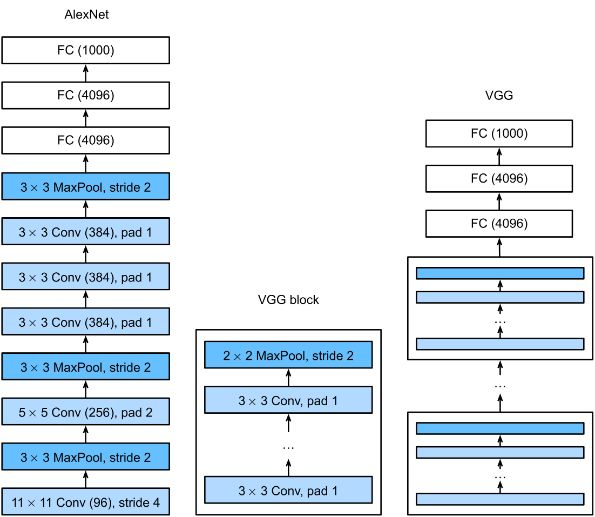

Misal kita ingin membuat VGG dengan 3 blok, 1 blok pertama memiliki layer konvolusi dengan channel berjumlah 32, dan 2 blok selanjutnya memiliki channel 64 dan 128 secara berurutan (Umumnya jumlah blok dan channel pada VGG tidak sesimpel ini, namun karena ini hanya untuk tujuan pembelajaran maka direduksi menjadi seperti itu).
<br><br>
**Implementasi Kode**

Pertama-tama kita membuat blok VGG dengan parameter jumlah blok dan jumlah channel

In [12]:
def vgg_block(num_block, num_channels):
    blk = keras.models.Sequential()
    for _ in range(num_block):
        blk.add(keras.layers.Conv2D(num_channels,kernel_size=3, padding='same',activation='relu'))
    blk.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

Selanjutnya kita membuat blok VGG network

In [13]:
def vgg_network(conv_arch):
    net = keras.models.Sequential()
    net.add(keras.layers.InputLayer(input_shape=(224,224,1)))

    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
        
    net.add(keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10)]))
    return net

Lalu mendefinisikan list yang berisi pasangan jumlah block dan channelnya, lalu memasukkannya sebagai parameter untuk blok ```vgg_network```

In [14]:
# Element pertama maksudnya 1 blok yang memiliki masing-masing 32 channel, elemen selanjutnya 1 block dengan 64 channel, dst..
conv_arch= [(1, 32), (1, 64), (1, 128)]

vgg= vgg_network(conv_arch)

Melakukan proses train, kita juga menggunakan data ```train_data_224``` sebagai data latih

In [15]:
loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True)
vgg.compile(optimizer='adam', loss= loss, metrics=['accuracy'])
vgg.fit(train_data_224, epochs= 3)

Epoch 1/3
469/469 [==============================] - 285s 603ms/step - loss: 0.2593 - accuracy: 0.9258
Epoch 2/3
469/469 [==============================] - 281s 599ms/step - loss: 0.0694 - accuracy: 0.9791
Epoch 3/3
469/469 [==============================] - 281s 599ms/step - loss: 0.0441 - accuracy: 0.9866


In [16]:
vgg.evaluate(test_data_224)

79/79 [==============================] - 17s 211ms/step - loss: 0.0573 - accuracy: 0.9843


[0.05728845298290253, 0.9843000173568726]

### 3. NiN

NiN (Network in Network) memiliki konsep yang mirip dengan VGG, yaitu pengimplementasian blok. Bedanya blok NiN terdiri dari satu layer konvolusi diikuti oleh dua layer konvolusi yang bertindak sebagai layer yang terhubung penuh per piksel dari gambar dengan aktivasi ReLU.
<br><br>
NiN menggunakan layer konvolusi dengan besar window 11 x 11 , 5 x 5, dan 3 x 3. Setiap blok NiN diikuti oleh maximum pooling layer dengan stride 2 dan besar window 3 x 3. Satu perbedaan signifikan antara NiN dan AlexNet adalah NiN tidak menggunakan layer FCN. Sebagai gantinya, blok NiN mempunyai output yang sama dengan jumlah label/class. Dan di akhir arsitektur NiN, terdapat layer global average pooling yang menghasilkan vektor logit. 

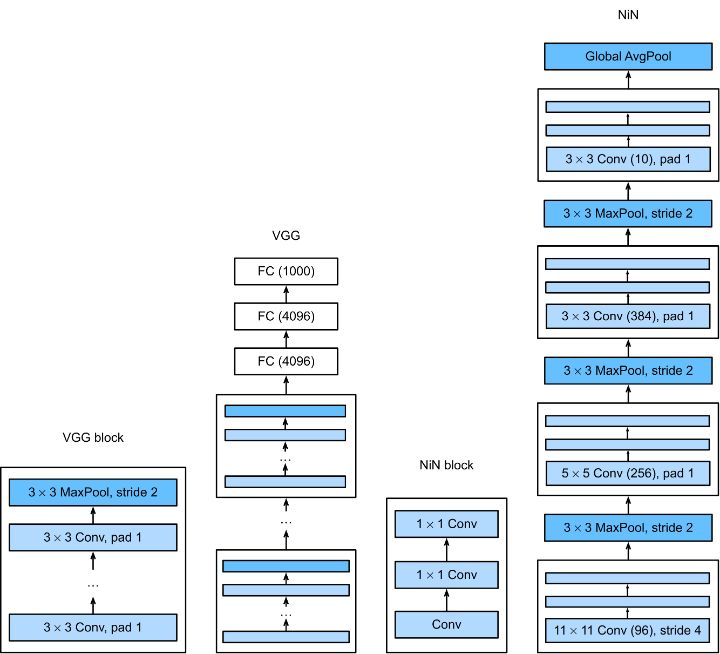

**Implementasi Kode**

In [17]:
# Membuat blok NiN
def nin_block(num_channels, kernel_size, strides, padding):
    return keras.models.Sequential([
        keras.layers.Conv2D(num_channels, kernel_size, strides=strides, padding=padding, activation='relu'),
        keras.layers.Conv2D(num_channels, kernel_size=1, activation='relu'),
        keras.layers.Conv2D(num_channels, kernel_size=1, activation='relu')])

# Membuat arsitektur NiN
def nin_network():
    return keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(224,224,1)),                  
        nin_block(96, kernel_size=11, strides=4, padding='valid'),
        keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding='same'),
        keras.layers.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding='same'),
        keras.layers.MaxPool2D(pool_size=3, strides=2),
        keras.layers.Dropout(0.5),
        nin_block(10, kernel_size=3, strides=1, padding='same'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Reshape((1, 1, 10)),
        keras.layers.Flatten(),
        ])
    
nin= nin_network()

In [18]:
nin.compile(optimizer='adam', loss= loss, metrics=['accuracy'])
nin.fit(train_data_224, epochs= 3)

Epoch 1/3
469/469 [==============================] - 126s 264ms/step - loss: 1.0295 - accuracy: 0.6353
Epoch 2/3
469/469 [==============================] - 250s 533ms/step - loss: 0.1584 - accuracy: 0.9547
Epoch 3/3
469/469 [==============================] - 254s 543ms/step - loss: 0.1017 - accuracy: 0.9717


In [21]:
nin.evaluate(test_data_224)

79/79 [==============================] - 15s 176ms/step - loss: 0.0668 - accuracy: 0.9800


[0.06677372753620148, 0.9800000190734863]

### 4. GoogLeNet

GoogLeNet merupakan arsitektur yang menggunakan blok inception sebagai blok konvolusinya.

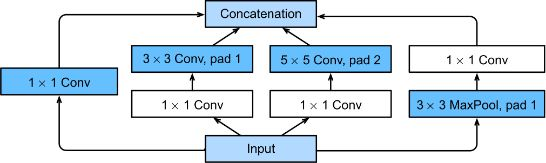

Blok inception terdiri dari empat jalur paralel. Tiga jalur pertama menggunakan layer konvolusi dengan ukuran jendela 1 x 1, 3 x 3, 5 x 5 dan untuk mengekstrak informasi dari ukuran yang berbeda. Dua jalur tengah melakukan konvolusi 1 x 1 pada input untuk mengurangi jumlah channel dan mengurangi kerumitan model. Jalur keempat menggunakan maximum pooling layer 3 x 3, diikuti oleh layer konvolusi 1 x 1 untuk mengubah jumlah channel. Keempat jalur semuanya menggunakan padding yang sesuai untuk memberikan input dan output dengan tinggi dan lebar yang sama. Akhirnya, output di setiap jalur sepanjang dimensi channel dan mengandung dari output dari blok tersebut. Hyperparameter yang biasa disetel dari blok Inception adalah jumlah channel keluaran per layer.
<br><br>
GoogLeNet mempunyai kedalaman sebesar 22 layer, dan menggunakan total 9 blok inception.

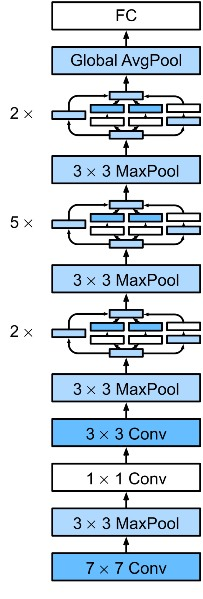

**Implementasi Kode**

Pertama-tama kita membuat blok inception

In [22]:
class Inception(keras.Model):
  
    # Parameter c1--c4 merupakan jumlah output channel dari setiap jalur
    def __init__(self, c1, c2, c3, c4):
        super().__init__()

        # Jalur pertama merupakan layer konvolusi dengan window 1x1
        self.p1_1 = keras.layers.Conv2D(c1, 1, activation='relu')

        # Jalur kedua berisi 2 layer konvolusi yang secara berurutan memiliki besar window 1 dan 3
        self.p2_1 = keras.layers.Conv2D(c2[0], 1, activation='relu')
        self.p2_2 = keras.layers.Conv2D(c2[1], 3, padding='same', activation='relu')

        # Jalur ketiga berisi 2 layer konvolusi yang secara berurutan memiliki besar window 1 dan 5
        self.p3_1 = keras.layers.Conv2D(c3[0], 1, activation='relu')
        self.p3_2 = keras.layers.Conv2D(c3[1], 5, padding='same', activation='relu')
        
        # Jalur keempat berisi 2 layer, layer pertama merupakan layer max pooling lalu layer konvolusi dengan window 1x1 
        self.p4_1 = keras.layers.MaxPool2D(3, 1, padding='same')
        self.p4_2 = keras.layers.Conv2D(c4, 1, activation='relu')


    def call(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Mengconcat output dari semua jalur ke dimensi channel
        return keras.layers.Concatenate()([p1, p2, p3, p4])

Selanjutnya kita membuat 5 blok konvolusi, 3 di antaranya merupakan blok inception.

In [23]:
def b1():
    return keras.models.Sequential([
        keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
    
def b2():
    return keras.Sequential([
        keras.layers.Conv2D(64, 1, activation='relu'),
        keras.layers.Conv2D(192, 3, padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
    
def b3():
    return keras.models.Sequential([
        Inception(64, (96, 128), (16, 32), 32),
        Inception(128, (128, 192), (32, 96), 64),
        keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
    
def b4():
    return keras.Sequential([
        Inception(192, (96, 208), (16, 48), 64),
        Inception(160, (112, 224), (24, 64), 64),
        Inception(128, (128, 256), (24, 64), 64),
        Inception(112, (144, 288), (32, 64), 64),
        Inception(256, (160, 320), (32, 128), 128),
        keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
    
def b5():
    return keras.Sequential([
        Inception(256, (160, 320), (32, 128), 128),
        Inception(384, (192, 384), (48, 128), 128),
        keras.layers.GlobalAvgPool2D(),
        keras.layers.Flatten()
    ])

Kemudian menyatukan semua blok, ditambah satu layer output

In [24]:
def googlenet_network():
    return keras.Sequential([b1(), b2(), b3(), b4(), b5(), keras.layers.Dense(10)])

google_net= googlenet_network()

In [25]:
google_net.compile(optimizer='adam', loss= loss, metrics=['accuracy'])
google_net.fit(train_data_224, epochs= 3)

Epoch 1/3
469/469 [==============================] - 410s 840ms/step - loss: 0.7235 - accuracy: 0.7390
Epoch 2/3
469/469 [==============================] - 391s 833ms/step - loss: 0.0844 - accuracy: 0.9754
Epoch 3/3
469/469 [==============================] - 391s 834ms/step - loss: 0.0534 - accuracy: 0.9839


In [26]:
google_net.evaluate(test_data_224)

79/79 [==============================] - 28s 333ms/step - loss: 0.0675 - accuracy: 0.9780


[0.06754763424396515, 0.9779999852180481]

### 5. Batch Normalization

Batch Normalization singkatnya merupakan proses normalisasi terhadap output dari layer sebelumnya. Mengapa dilakukan normalisasi? biasanya output dari suatu layer mempunyai rentang yang besar (walaupun inputnya sudah ternormalisasi terlebih dahulu), ini menyebabkan proses feed ke layer selanjutnya kurang baik dan model tidak general, maka dilakukan normalisasi untuk men-skala output menjadi lebih seimbang.

Di sini kita menggunakan arsitektur CNN yang simpel

In [27]:
model_batchnorm= keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', input_shape= (28, 28, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    keras.layers.MaxPool2D(pool_size=3, strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(10)
])

Karena tidak terikat dengan arsitektur, maka kita bisa menggunakan data yang tidak diresize

In [29]:
model_batchnorm.compile(optimizer='adam', loss= loss, metrics=['accuracy'])
model_batchnorm.fit(x_train, y_train, epochs= 5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 9s 16ms/step - loss: 0.0903 - accuracy: 0.9734
Epoch 2/5
469/469 [==============================] - 7s 15ms/step - loss: 0.0659 - accuracy: 0.9803
Epoch 3/5
469/469 [==============================] - 7s 15ms/step - loss: 0.0567 - accuracy: 0.9821
Epoch 4/5
469/469 [==============================] - 7s 15ms/step - loss: 0.0473 - accuracy: 0.9854
Epoch 5/5
469/469 [==============================] - 7s 15ms/step - loss: 0.0415 - accuracy: 0.9874


In [30]:
model_batchnorm.evaluate(x_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.0687 - accuracy: 0.9841


[0.06874813884496689, 0.9840999841690063]

### 6. ResNet {--Todo--}

ResNet (Residual Network)

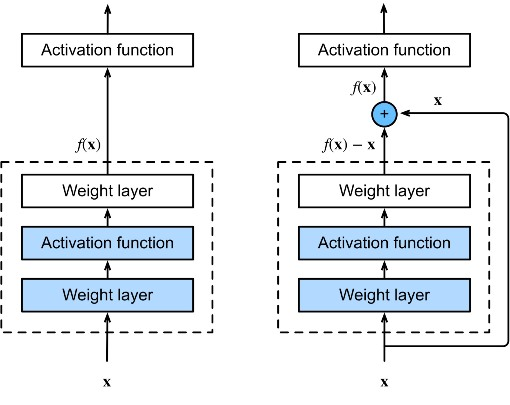

Blok residual

In [ ]:
class Residual(keras.Model):  
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = keras.layers.Conv2D(num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = keras.layers.Conv2D(num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = keras.layers.Conv2D(num_channels, kernel_size=1, strides=strides)
        self.bn1 = keras.layers.BatchNormalization()
        self.bn2 = keras.layers.BatchNormalization()

    def call(self, X):
        Y = keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return keras.activations.relu(Y)

Blok ResNet

In [ ]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False, **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

Membuat arsitektur ResNet

In [ ]:
b1 = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
])

b2 = ResnetBlock(64, 2, first_block=True)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

def resnet_network():
    return keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        keras.layers.GlobalAvgPool2D(),
        keras.layers.Dense(units=10)])

resnet= resnet_network()

In [ ]:
resnet.compile(optimizer='adam', loss= loss, metrics=['accuracy'])
resnet.fit(train_data_224, epochs= 3)

In [ ]:
resnet.evaluate(test_data_224)

### 7. DenseNet {--Todo--}

DenseNet (Densely Connected Networks)

Perbedaan antara ResNet dengan DenseNet

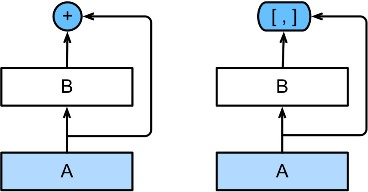

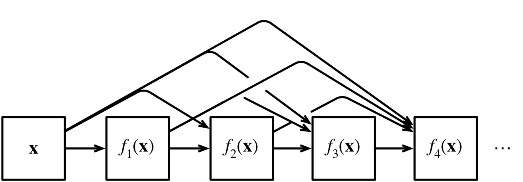

In [ ]:
class ConvBlock(keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn = keras.layers.BatchNormalization()
        self.relu = keras.layers.ReLU()
        self.conv = keras.layers.Conv2D(filters=num_channels, kernel_size=(3, 3), padding='same')

        self.listLayers = [self.bn, self.relu, self.conv]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        y = keras.layers.concatenate([x,y], axis=-1)
        return y

In [ ]:
class DenseBlock(keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

In [ ]:
class TransitionBlock(keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = keras.layers.BatchNormalization()
        self.relu = keras.layers.ReLU()
        self.conv = keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, x):
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        return self.avg_pool(x)

In [ ]:
def block_1():
    return keras.Sequential([
       keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
       keras.layers.BatchNormalization(),
       keras.layers.ReLU(),
       keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])
    
def block_2():
    net = block_1()
    # `num_channels`: the current number of channels
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [4, 4, 4, 4]

    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        net.add(DenseBlock(num_convs, growth_rate))
        # This is the number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(num_convs_in_dense_blocks) - 1:
            num_channels //= 2
            net.add(TransitionBlock(num_channels))
    return net

def densenet_network():
    net = block_2()
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.ReLU())
    net.add(keras.layers.GlobalAvgPool2D())
    net.add(keras.layers.Flatten())
    net.add(keras.layers.Dense(10))
    return net

In [ ]:
dense_net= densenet_network()

dense_net.compile(optimizer='adam', loss= loss, metrics=['accuracy'])
dense_net.fit(train_data_224, epochs= 3)

In [ ]:
dense_net.evaluate(test_data_224)